In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import tweepy

%matplotlib notebook

In [418]:
PATH_TO_TIME_SERIES = r'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
FILE_NAME_PREFIX = 'time_series_19-covid-'
FILE_SUFFIXES = ['Confirmed', 'Deaths', 'Recovered']
EXT = '.csv'

FIG_SIZE = (7, 4.5)

def get_path(suffix):
    file_name = FILE_NAME_PREFIX + suffix + EXT
    p = os.path.join(PATH_TO_TIME_SERIES, file_name)
    return p

def get_doubling_times(dates, data, window=1, limit=100):
    """
    Get rolling doubling times
    """
    day_numbers = (dates.year-2020)*365 + dates.dayofyear
    
    doubling_times = []
    
    # rolling linear fit, window size w
    w = window
    for ii in range(w, (day_numbers.size-w)):
        start_pos = ii-w
        end_pos = ii+w+1
        
        if np.mean(data[start_pos:end_pos]) < limit:
            doubling_times.append(np.nan)
        else:
            days_to_fit = day_numbers[start_pos:end_pos]
            n_to_fit = np.log(data[start_pos:end_pos])
            p = np.polyfit(days_to_fit, n_to_fit, 1)

            doubling_time = 1/p[0]*np.log(2)


            if doubling_time < 0:
                doubling_time = 0

            doubling_times.append(doubling_time)

    np_out = np.array(doubling_times)
    return np_out

def get_days_to_n_cases(doubling_time, cases_now, cases_proj):
    factor_to_go = cases_proj / cases_now    
    doubling_times_to_go = np.log(factor_to_go)/np.log(2)
    
    doubling_times_to_go[doubling_times_to_go<0] = 0
    
    return doubling_times_to_go*doubling_time

def new_fig_ax():
    f = plt.figure(figsize=FIG_SIZE)
    a = f.add_subplot(111)
    return f, a

def new_31sp():
    f = plt.figure(figsize=(6, 15))
    
    ax = ['', '', '']
    ax[0] = f.add_subplot(3, 1, 1)
    ax[1] = f.add_subplot(3, 1, 2)
    ax[2] = f.add_subplot(3, 1, 3)
    return f, ax

In [349]:
dfs = []

for suffix in FILE_SUFFIXES:
    path = get_path(suffix)
    df = pd.read_csv(path)
    dfs.append(df)

confirmed_cases = {}
doubling_times = {}
deaths_ = {}
death_doubling_times = {}
countries = ['United Kingdom', 'Italy', 'Spain', 'Germany', 'France', 'US', 'China', 'Korea, South', 'Japan']

<IPython.core.display.Javascript object>


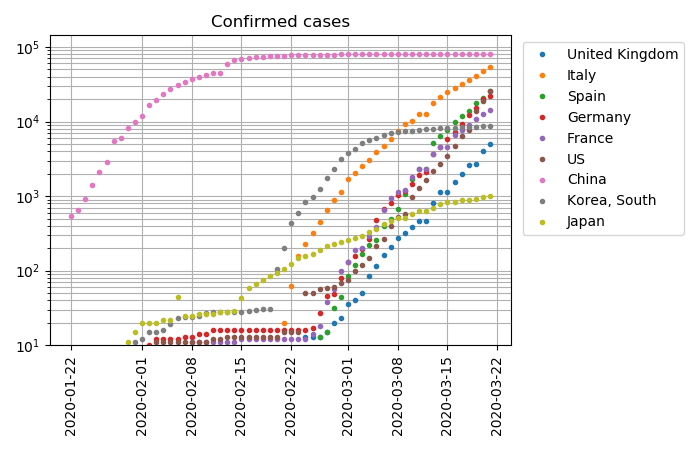

<IPython.core.display.Javascript object>


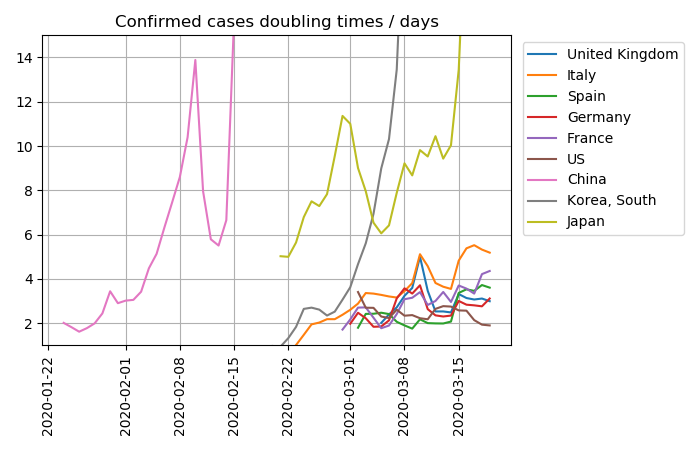

<IPython.core.display.Javascript object>


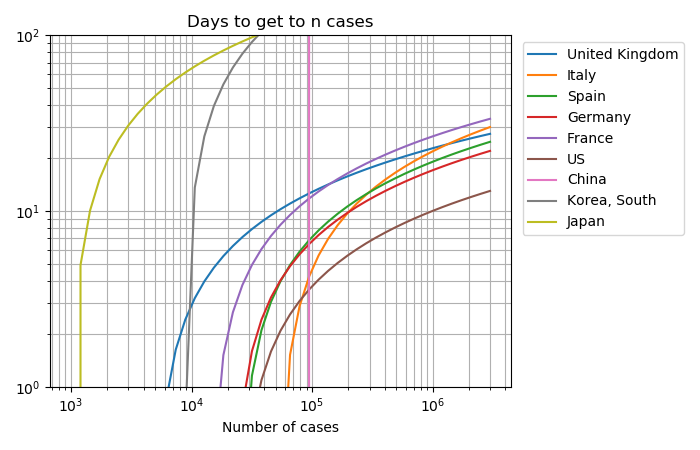

<IPython.core.display.Javascript object>


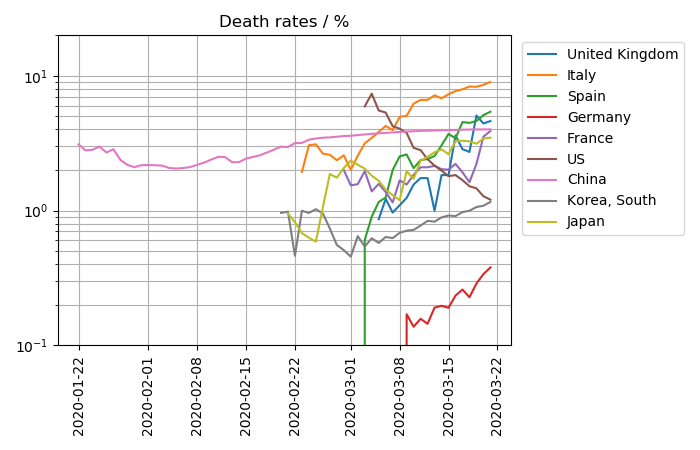

<IPython.core.display.Javascript object>


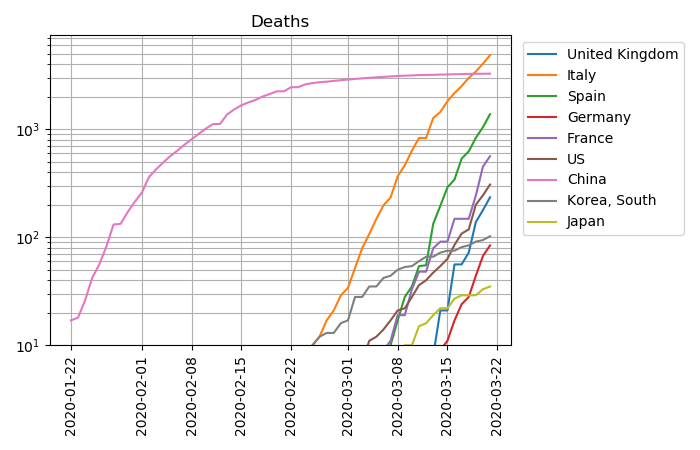

<IPython.core.display.Javascript object>


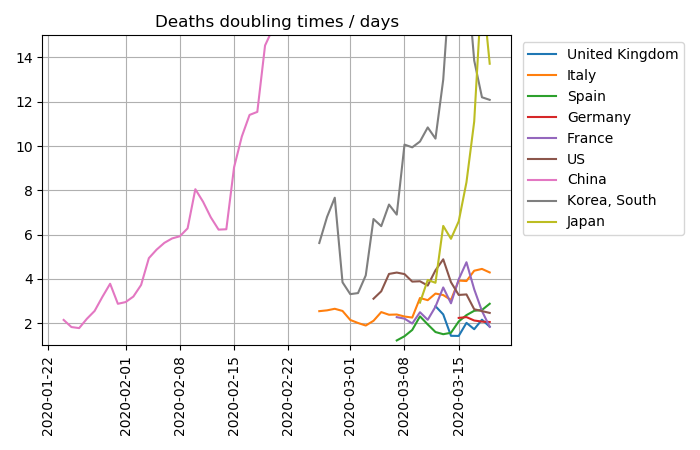

<IPython.core.display.Javascript object>


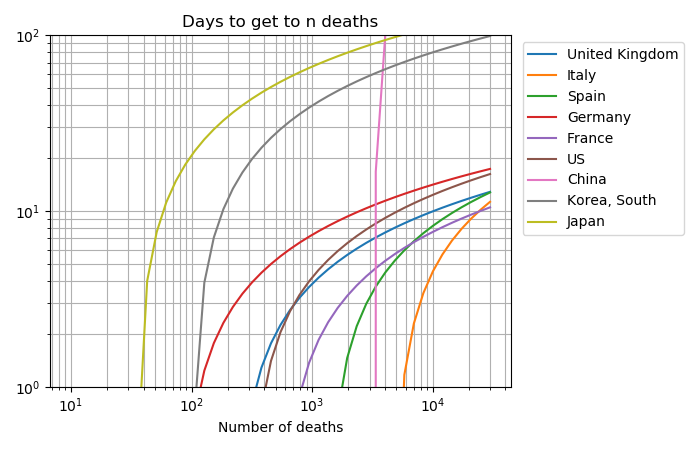

In [419]:
window = 2
n_cases_proj = np.logspace(3, np.log10(3e6), 45);

f1, ax1 = new_fig_ax()
f2, ax2 = new_fig_ax()
f3, ax3 = new_fig_ax()
f4, ax4 = new_fig_ax()
f5, ax5 = new_fig_ax()
f6, ax6 = new_fig_ax()
f7, ax7 = new_fig_ax()

#fc, axc = new_31sp()
#ax1, ax2, ax3 = axc
#f4, ax4 = new_fig_ax()

#fd, axd = new_31sp()
#ax5, ax6, ax7 = axd

dates = pd.to_datetime(dfs[0].iloc[:, 4:].columns, format='%m/%d/%y')

for c in countries:
    confirmed = dfs[0].loc[dfs[0]['Country/Region'] == c]
    deaths = dfs[1].loc[dfs[1]['Country/Region'] == c]

    n = confirmed.iloc[:,4:].sum()
    x = deaths.iloc[:, 4:].sum()

    confirmed_cases[c] = n
    deaths_[c] = x

    ax1.plot_date(dates, n, '.', label=c)
    
    d = get_doubling_times(dates, n, window=window)
    doubling_times[c] = d

    ax2.plot_date(dates[window:-window], d, '-', label=c)
    
    days_to_n_cases = get_days_to_n_cases(d[-1], n[-1], n_cases_proj)

    ax3.plot(n_cases_proj, days_to_n_cases, label=c)
    
    death_rate_pct = 100*x/n
    death_rate_pct[n<100] = np.nan
    ax4.plot_date(dates, death_rate_pct, '-', label=c)
    
    ax5.plot_date(dates, x, '-', label=c)
    
    dd = get_doubling_times(dates, x, window=window, limit=10)
    death_doubling_times[c] = dd
    ax6.plot_date(dates[window:-window], dd, '-', label=c)
    
    d_days_to_n_cases = get_days_to_n_cases(dd[-1], x[-1], n_cases_proj*0.01)
    ax7.plot(n_cases_proj*0.01, d_days_to_n_cases, label=c)
    

ax1.legend(bbox_to_anchor=(1.01, 1))
ax1.set_yscale('log')
ax1.set_ylim(10, )
ax1.set_title('Confirmed cases')
plt.sca(ax1)
ax1.grid(which='both', axis='both')
plt.xticks(rotation=90)
f1.tight_layout()

ax2.legend(bbox_to_anchor=(1.01, 1))
ax2.set_ylim(0, 15)
ax2.set_title('Confirmed cases doubling times / days')
plt.sca(ax2)
#ax2.set_yscale('log')
ax2.set_ylim(1, 15)
ax2.grid(which='both', axis='both')
plt.xticks(rotation=90)
f2.tight_layout()

ax3.legend(bbox_to_anchor=(1.01, 1))
ax3.set_title('Days to get to n cases')
ax3.set_xlabel('Number of cases')
ax3.set_xscale('log')
ax3.set_ylim(1, 100)
ax3.set_yscale('log')
ax3.grid(which='both', axis='both')
f3.tight_layout()

ax4.legend(bbox_to_anchor=(1.01, 1))
ax4.set_title('Death rates / %')
ax4.set_ylim(.1, 20)
ax4.set_yscale('log')
ax4.grid(which='both', axis='both')
plt.sca(ax4)
plt.xticks(rotation=90)
f4.tight_layout()

ax5.legend(bbox_to_anchor=(1.01, 1))
ax5.set_yscale('log')
ax5.set_ylim(10, )
ax5.set_title('Deaths')
ax5.grid(which='both', axis='both')
plt.sca(ax5)
plt.xticks(rotation=90)
f5.tight_layout()

ax6.legend(bbox_to_anchor=(1.01, 1))
ax6.set_ylim(0, 15)
ax6.set_title('Deaths doubling times / days')
plt.sca(ax6)
#ax2.set_yscale('log')
ax6.set_ylim(1, 15)
ax6.grid(which='both', axis='both')
plt.xticks(rotation=90)
f6.tight_layout()

ax7.legend(bbox_to_anchor=(1.01, 1))
ax7.set_title('Days to get to n deaths')
ax7.set_xlabel('Number of deaths')
ax7.set_xscale('log')
ax7.set_ylim(1, 100)
ax7.set_yscale('log')
ax7.grid(which='both', axis='both')
f7.tight_layout()

f1.savefig('confirmed.png')
f2.savefig('confirmed_doubling_times.png')
f3.savefig('confirmed_days_to_n.png')
f4.savefig('death_rate.png')
f5.savefig('deaths.png')
f6.savefig('deaths_doubling_times.png')
f7.savefig('deaths_days_to_n.png')

In [407]:
with open('twitterdevkeys.txt', 'r') as f:
    txt = f.readlines()

elements = [a.split(',') for a in txt]
keys = {}
for a in elements:
    keys[a[0]] = a[1].rstrip()

In [376]:


auth = tweepy.OAuthHandler(keys['API key'], keys['API key secret'])
auth.set_access_token(keys['Access token'], keys['Access token secret'])

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [421]:
def to_ordinal(cardinal):
    suffices = ["th", "st", "nd", "rd"]

    if cardinal % 10 in [1, 2, 3] and cardinal not in [11, 12, 13]:
        return suffices[cardinal % 10]
    else:
        return suffices[0]

def get_time_str():
    string = f"{now.hour}:{now.minute} on {now.day}{foo(now.day):s} {now.strftime('%b %Y')}"
    return string

def thank(s):
    ack_str = '. Data from @JHUSystems'
    return s + ack_str

def tweet_pic_with_thanks(fname, msg):
    time_str = get_time_str()
    full_message = msg + f' at {time_str}'
    t = api.update_with_media(fname, thank(full_message))
    return t

t1 = tweet_pic_with_thanks('deaths.png', '#COVID19 death stats')
t2 = tweet_pic_with_thanks('deaths_doubling_times.png', '#COVID19 death doubling times')
t3 = tweet_pic_with_thanks('deaths_days_to_n.png', '#COVID19 death predictions')
t4 = tweet_pic_with_thanks('confirmed_days_to_n.png', '#COVID19 case number predictions')